In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

def load_mnist(filename):
    with open(filename, "r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f]
    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)


batch_size = 64
train_loader_classic = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data', 
        train=True, 
        download=False, 
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), 
    batch_size=batch_size, 
    shuffle=True)

print("Loading...")
batch_size = 64

def load(name_train, name_test):
    train = load_mnist(name_train)
    test = load_mnist(name_test)
    trainset_2 = torch.utils.data.TensorDataset(torch.from_numpy(train[0]).type(torch.FloatTensor), torch.from_numpy(train[1]).type(torch.LongTensor))
    testset_2 = torch.utils.data.TensorDataset(torch.from_numpy(test[0]).type(torch.FloatTensor), torch.from_numpy(test[1]).type(torch.LongTensor))
    train_loader_random = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True) 
    test_loader_random = torch.utils.data.DataLoader(testset_2, batch_size=batch_size, shuffle=True)
    return train_loader_random, test_loader_random

train_loader_random, test_loader_random = load(
    '/Users/valentin/Downloads/mnist_background_random/mnist_background_random_train.amat',
    '/Users/valentin/Downloads/mnist_background_random/mnist_background_random_test.amat')

print("fin")

Loading...
fin


In [3]:
class Highway(nn.Module):
    """https://github.com/kefirski/pytorch_Highway/blob/master/highway/highway.py"""
    def __init__(self, size, num_layers, f):
        super(Highway, self).__init__()
        self.num_layers = num_layers
        self.nonlinear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.linear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.gate = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.f = f

    def forward(self, x):
        """
            :param x: tensor with shape of [batch_size, size]
            :return: tensor with shape of [batch_size, size]
            applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
            """
        for layer in range(self.num_layers):
            gate = F.sigmoid(self.gate[layer](x))
            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)
            x = gate * nonlinear + (1 - gate) * linear
        return x
    
class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.list_module = nn.ModuleList()
        
    def forward(self, x):
        for i in range(0, len(self.list_module)):
            x = self.list_module[i](x)
        return x
    
    
def forward(data, target):
    data = data.view(-1, 28*28)
    batch_size = data.size()[0]
    y_onehot = torch.FloatTensor(batch_size, 10) 
    y_onehot.zero_()
    y_onehot = y_onehot - 1
    y_onehot.scatter_(1, target.view(-1,1), 1)
    target = y_onehot
    optimizer.zero_grad()
    x = Variable(data)
    y = Variable(target)
    """out = m(x)
    out2 = t(out)
    err = l(out2)"""
    out = m(x)
    err = l(out, y)
    return err
    
def train(train_loader, nb_epoch, test_loader_random):
    list_err = []
    for j in range(0, nb_epoch):
        for i,(data,target) in enumerate(train_loader):
            err = forward(data, target)
            list_err.append(torch.mean(err.data))
            err.backward()
            optimizer.step()
        if j%10 == 0:
            print("Epoch : "+str(j))
            test(test_loader_random)
    return list_err
            
def test(test_loader):
    list_test = []
    for i,(data,target) in enumerate(test_loader):
        err = forward(data, target)
        list_test.append(torch.mean(err.data))
    print("Erreur Test : "+str(sum(list_test)/len(list_test)))
    
def show(list_err, nom):
    print("Train Loss "+nom)
    plt.plot(np.arange(0, len(list_err)), list_err)
    plt.show()
        

nb_epoch = 100
#N = train_loader_random.dataset.train_data.size()[0]
N = 50000
taux_test = 0.2
l = nn.MSELoss()

Epoch : 0
Erreur Test : 0.38204101913268
Epoch : 10
Erreur Test : 0.331483430074304
Epoch : 20
Erreur Test : 0.3000034700193064
Epoch : 30
Erreur Test : 0.2793667657524728
Epoch : 40
Erreur Test : 0.2654529538224725
Epoch : 50
Erreur Test : 0.2555283619391034
Epoch : 60
Erreur Test : 0.24839336851902324
Epoch : 70
Erreur Test : 0.24298760729372654
Epoch : 80
Erreur Test : 0.23879403567603788
Epoch : 90
Erreur Test : 0.2352424091123559
Train Loss Random Lineaire 1 couche


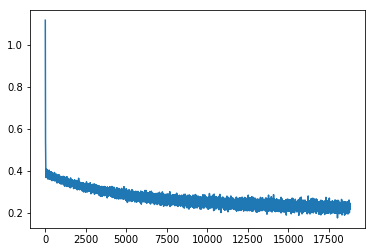

In [4]:
class ModelLineaire1Couche(Model):
    def __init__(self):
        Model.__init__(self)
        self.list_module.append(nn.Linear(784, 10))
        
m = ModelLineaire1Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_random, nb_epoch, test_loader_random)
show(list_err, "Random Lineaire 1 couche")

Epoch : 0
Erreur Test : 0.86176457726742
Epoch : 10
Erreur Test : 0.3617506945300895
Epoch : 20
Erreur Test : 0.3603099942435999
Epoch : 30
Erreur Test : 0.3601910643794043
Epoch : 40
Erreur Test : 0.360072571450792
Epoch : 50
Erreur Test : 0.3599531495052835
Epoch : 60
Erreur Test : 0.3598294405985976
Epoch : 70
Erreur Test : 0.3597042523991421
Epoch : 80
Erreur Test : 0.3595788905687649
Epoch : 90
Erreur Test : 0.3594508682904036
Train Loss Random Highway 3+2 couches


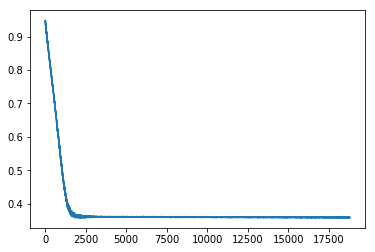

In [5]:
class ModelHighway(Model):
    def __init__(self):
        Model.__init__(self)
        self.list_module.append(nn.Linear(784, 50))
        self.list_module.append(Highway(50, 3, F.tanh))
        self.list_module.append(nn.Linear(50, 10))

m = ModelHighway()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_random, nb_epoch, test_loader_random)
show(list_err, "Random Highway 3+2 couches")

Epoch : 0
Erreur Test : 0.6282084767928209
Epoch : 10
Erreur Test : 0.3603635262269193
Epoch : 20
Erreur Test : 0.35941225187400416
Epoch : 30
Erreur Test : 0.35842820598036434
Epoch : 40
Erreur Test : 0.35738953201057355
Epoch : 50
Erreur Test : 0.35623468694936894
Epoch : 60
Erreur Test : 0.35493140707692833
Epoch : 70
Erreur Test : 0.3534308474158387
Epoch : 80
Erreur Test : 0.35165451390816427
Epoch : 90
Erreur Test : 0.3495372617259965
Train Loss Random Lineaire 5 couches


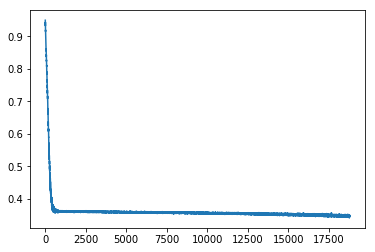

In [6]:
class ModelLineaire5Couche(Model):
    def __init__(self):
        Model.__init__(self)
        self.list_module.append(nn.Linear(784, 50))
        self.list_module.append(nn.Linear(50, 50))
        self.list_module.append(nn.Linear(50, 50))
        self.list_module.append(nn.Linear(50, 50))
        self.list_module.append(nn.Linear(50, 10))
        
m = ModelLineaire5Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_random, nb_epoch, test_loader_random)
show(list_err, "Random Lineaire 5 couches")

In [7]:
print("Loading...")
train_loader_background, test_loader_background = load(
    '/Users/valentin/Downloads/mnist_background_images/mnist_background_images_train.amat',
    '/Users/valentin/Downloads/mnist_background_images/mnist_background_images_test.amat')
print("fin")

Loading...
fin


Epoch : 0
Erreur Test : 0.40507671115038646
Epoch : 10
Erreur Test : 0.3428925585640056
Epoch : 20
Erreur Test : 0.31295599047180334
Epoch : 30
Erreur Test : 0.2961539671853985
Epoch : 40
Erreur Test : 0.2855963678768529
Epoch : 50
Erreur Test : 0.27838758032416444
Epoch : 60
Erreur Test : 0.2732472796459942
Epoch : 70
Erreur Test : 0.2693668791400197
Epoch : 80
Erreur Test : 0.2662330740476813
Epoch : 90
Erreur Test : 0.2638257110629545
Train Loss Background Lineaire 1 couche


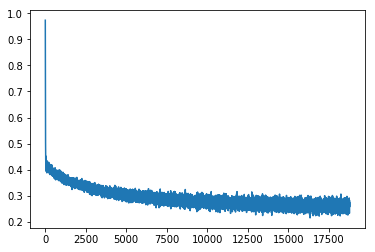

In [8]:
m = ModelLineaire1Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_background, nb_epoch, test_loader_background)
show(list_err, "Background Lineaire 1 couche")

Epoch : 0
Erreur Test : 0.8927472139258519
Epoch : 10
Erreur Test : 0.37012057128312337
Epoch : 20
Erreur Test : 0.3658972425610208
Epoch : 30
Erreur Test : 0.36464694996014274
Epoch : 40
Erreur Test : 0.3636224971479162
Epoch : 50
Erreur Test : 0.3627549587460735
Epoch : 60
Erreur Test : 0.3620343648487955
Epoch : 70
Erreur Test : 0.3614087644059335
Epoch : 80
Erreur Test : 0.3608763413813413
Epoch : 90
Erreur Test : 0.36041285543490553
Train Loss Random Highway 3+2 couches


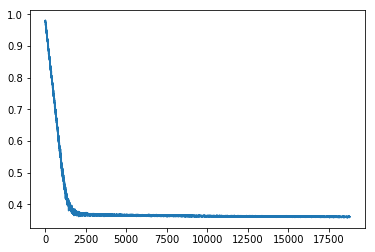

In [9]:
m = ModelHighway()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_background, nb_epoch, test_loader_background)
show(list_err, "Background Highway 3+2 couches")

Epoch : 0
Erreur Test : 0.6922239930276066
Epoch : 10
Erreur Test : 0.37807849045757136
Epoch : 20
Erreur Test : 0.3740827456078566
Epoch : 30
Erreur Test : 0.37050679745271686
Epoch : 40
Erreur Test : 0.36719444676128493
Epoch : 50
Erreur Test : 0.3640266094747407
Epoch : 60
Erreur Test : 0.3609095807270626
Epoch : 70
Erreur Test : 0.35772641128896143
Epoch : 80
Erreur Test : 0.3544015924034216
Epoch : 90
Erreur Test : 0.35077897491662396
Train Loss Background Lineaire 5 couches


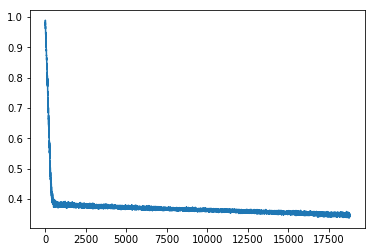

In [10]:
m = ModelLineaire5Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_background, nb_epoch, test_loader_background)
show(list_err, "Background Lineaire 5 couches")

In [12]:
print("Loading...")
train_loader_classic, test_loader_classic = load(
    '/Users/valentin/Downloads/mnist/mnist_train.amat',
    '/Users/valentin/Downloads/mnist/mnist_test.amat')
print("fin")

Loading...
fin


Epoch : 0
Erreur Test : 0.4210012267388956
Epoch : 10
Erreur Test : 0.2708772985488557
Epoch : 20
Erreur Test : 0.24374818533201656
Epoch : 30
Erreur Test : 0.23078466364947123
Epoch : 40
Erreur Test : 0.22263539538663976
Epoch : 50
Erreur Test : 0.21669980271926623
Epoch : 60
Erreur Test : 0.21227775763748857
Epoch : 70
Erreur Test : 0.2085725359447167
Epoch : 80
Erreur Test : 0.20546759552586719
Epoch : 90
Erreur Test : 0.20276725296016848
Train Loss Classic Lineaire 1 couche


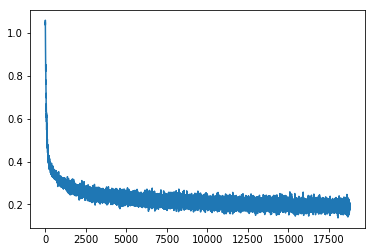

In [13]:
m = ModelLineaire1Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_classic, nb_epoch, test_loader_classic)
show(list_err, "Classic Lineaire 1 couche")

Epoch : 0
Erreur Test : 0.9145307416653694
Epoch : 10
Erreur Test : 0.5349607456980459
Epoch : 20
Erreur Test : 0.3846040409620461
Epoch : 30
Erreur Test : 0.3608879124569466
Epoch : 40
Erreur Test : 0.35889675012787287
Epoch : 50
Erreur Test : 0.3580306050417673
Epoch : 60
Erreur Test : 0.3571907930133288
Epoch : 70
Erreur Test : 0.35629932929182906
Epoch : 80
Erreur Test : 0.3553161169485668
Epoch : 90
Erreur Test : 0.3542007332491448
Train Loss Background Highway 3+2 couches


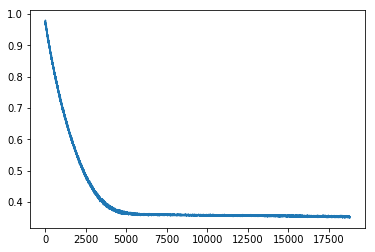

In [14]:
m = ModelHighway()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_classic, nb_epoch, test_loader_classic)
show(list_err, "Background Highway 3+2 couches")

Epoch : 0
Erreur Test : 0.9159611069485355
Epoch : 10
Erreur Test : 0.3671760528212618
Epoch : 20
Erreur Test : 0.3594646087616606
Epoch : 30
Erreur Test : 0.35158158564354147
Epoch : 40
Erreur Test : 0.34208139567576407
Epoch : 50
Erreur Test : 0.33012477020778314
Epoch : 60
Erreur Test : 0.31614115117760877
Epoch : 70
Erreur Test : 0.3019353772901818
Epoch : 80
Erreur Test : 0.2887950543781071
Epoch : 90
Erreur Test : 0.2775005512606457
Train Loss Background Lineaire 5 couches


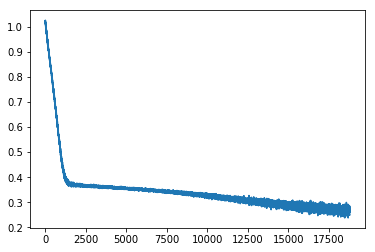

In [15]:
m = ModelLineaire5Couche()
optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
list_err = train(train_loader_classic, nb_epoch, test_loader_classic)
show(list_err, "Background Lineaire 5 couches")